In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pymc as pm
import arviz as az

import sys
sys.path.insert(1, '../src')
from bayesian_change_point_model import BayesianChangePointModel

In [ ]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
df = df.set_index('Date').sort_index()
df['Price'] = df['Price'].ffill()
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))

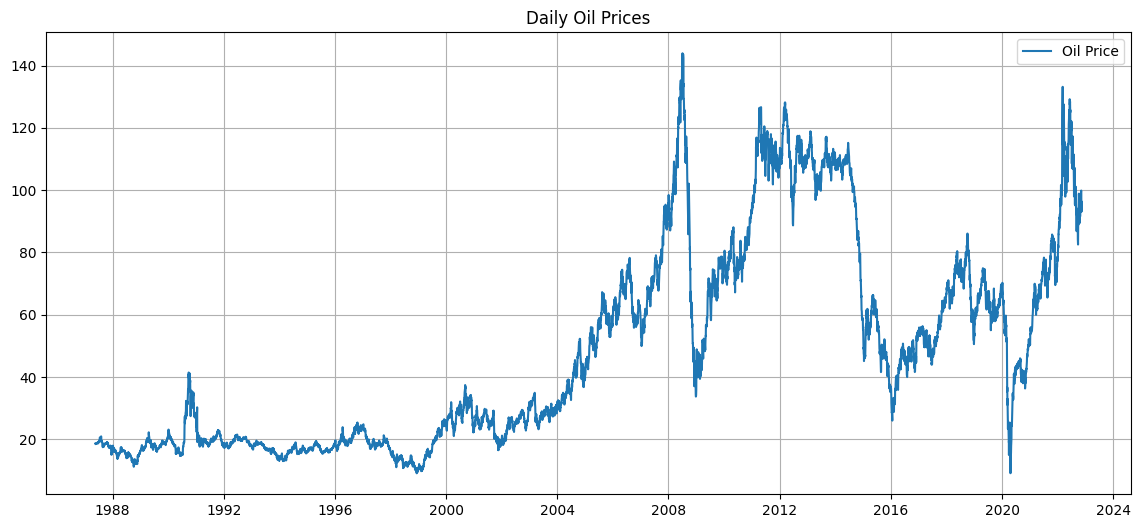

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(df["Price"], label="Oil Price")
plt.title("Daily Oil Prices")
plt.legend()
plt.grid(True)
plt.show()

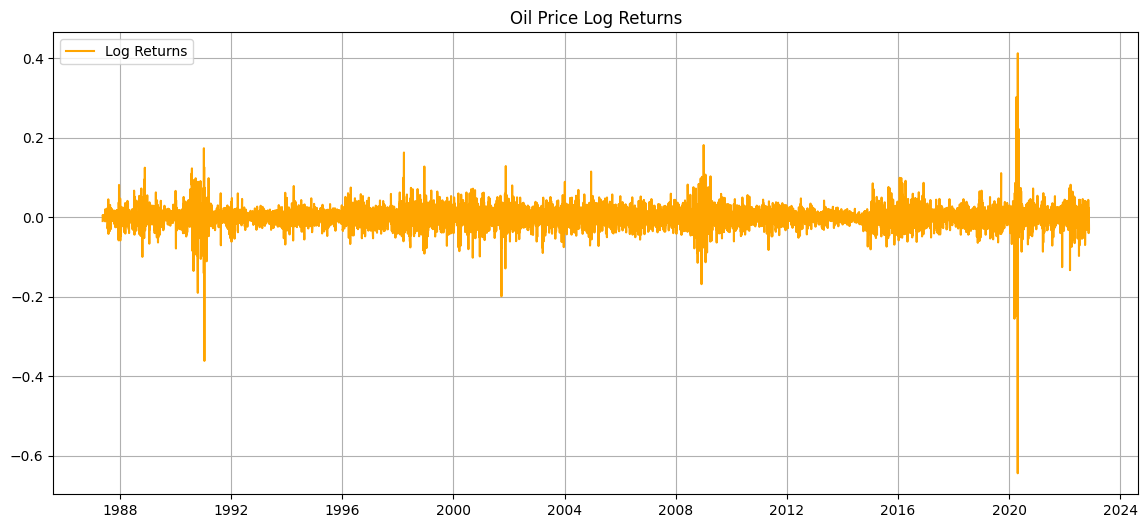

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df["log_Return"], label="Log Returns", color="orange")
plt.title("Oil Price Log Returns")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
result = adfuller(df["Log_Return"].dropna())
print(f"ADF Statistic: {result[0]:.3f}")
print(f"p-value: {result[1]:.3f}")

ADF Statistic: -16.427
p-value: 0.000


In [11]:
returns = df["log_Return"].dropna().values
N = len(returns)

with pm.Model() as model:
    tau = pm.DiscreteUniform("tau", lower=0, upper=N)

    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)

    idx = np.arange(N)
    mu = pm.math.switch(tau >= idx, mu1, mu2)
    sigma = pm.math.switch(tau >= idx, sigma1, sigma2)

    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns)

    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma1, sigma2]


Output()

ValueError: Not enough samples to build a trace.

In [ ]:
# Initialize and run the model
bcp = BayesianChangePointModel()
bcp.create_model(df["log_Return"])
bcp.fit()

tau_date = df["Date"].iloc[bcp.tau]
print(f"Estimated Change Point: {tau_date.date()}")

# Optional: Save the model for future use
bcp.save("oil_model.pkl")

KeyError: 'Log_Return'